# Лабораторная работа 1. Линейная регрессия и факторный анализ.

**Цель работы:** изучение основ линейной регрессии, построение простейших моделей регрессии, проведение обучения модели на реальных данных и оценка её качества.

**Датасет:** https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction/data

Набор данных содержит информацию о вариантах бронирования авиабилетов на сайте Easemytrip для перелетов между 6 крупнейшими мегаполисами Индии. В очищенном наборе данных содержится 300 261 точка данных и 11 объектов.

Ниже описаны различные признаки очищенного набора данных:
1) Авиакомпания: Название авиакомпании хранится в столбце «авиакомпания». Это категориальный признак, содержащий данные о 6 различных авиакомпаниях.
2) Рейс: В столбце «Рейс» хранится информация о коде рейса. Это категориальный признак.
3) Город отправления: Город, из которого вылетает рейс. Это категориальный признак, содержащий данные о 6 уникальных городах.
4) Время отправления: Это производный категориальный признак, полученный путем группировки временных интервалов в группы. Он хранит информацию о времени отправления и имеет 6 уникальных меток времени.
5) Остановки: Категориальный признак с 3 различными значениями, который хранит количество остановок между городами отправления и назначения.
6) Время прибытия: Это производный категориальный признак, созданный путем группировки временных интервалов в группы. Он имеет шесть различных меток времени и содержит информацию о времени прибытия.
7) Город назначения: Город, в котором приземлится рейс. Это категориальный признак, относящийся к 6 уникальным городам.
8) Класс: Категориальный признак, содержащий информацию о классе места; имеет два различных значения: Бизнес и Эконом.
9) Продолжительность: Непрерывный признак, отображающий общее время в пути между городами в часах.
10) Осталось дней: Это производная характеристика, которая рассчитывается путем вычитания даты поездки из даты бронирования.
11) Цена: Переменная Target хранит информацию о цене билета.

## Загружаем датасет и удаляем колонки, где отсутствует хотя бы одно значение

In [34]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.decomposition import PCA
import numpy as np

filename = 'data/dataset.csv'
cat_cols = ['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class']
num_cols = ['days_left', 'duration']
dep_var = 'price'

data = pd.read_csv(filename, usecols=[*cat_cols, *num_cols, dep_var])

data.dropna(inplace=True)

data


,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
...,...,...,...,...,...,...,...,...,...,...
300148,Vistara,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,Vistara,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,Vistara,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,Vistara,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585


## Первичный анализ
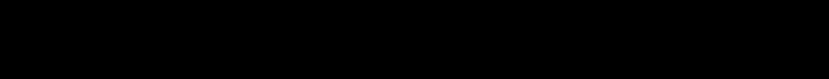
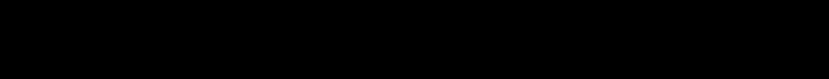

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   source_city       300153 non-null  object 
 2   departure_time    300153 non-null  object 
 3   stops             300153 non-null  object 
 4   arrival_time      300153 non-null  object 
 5   destination_city  300153 non-null  object 
 6   class             300153 non-null  object 
 7   duration          300153 non-null  float64
 8   days_left         300153 non-null  int64  
 9   price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 22.9+ MB


In [36]:
data_stats = data.describe()
data_stats

,duration,days_left,price
count,300153.000000,300153.000000,300153.000000
mean,12.221021,26.004751,20889.660523
std,7.191997,13.561004,22697.767366
min,0.830000,1.000000,1105.000000
25%,6.830000,15.000000,4783.000000
50%,11.250000,26.000000,7425.000000
75%,16.170000,38.000000,42521.000000
max,49.830000,49.000000,123071.000000


## Визуализирование распределения признаков и целевой переменной

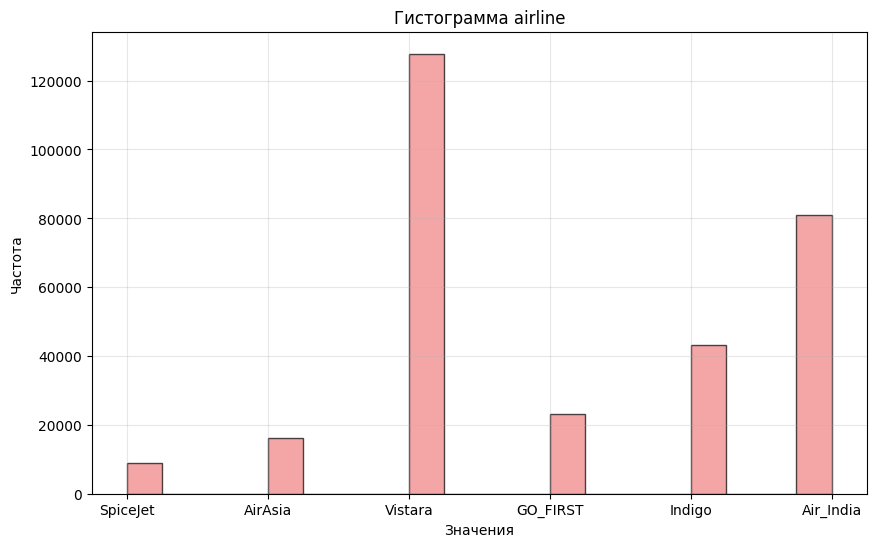

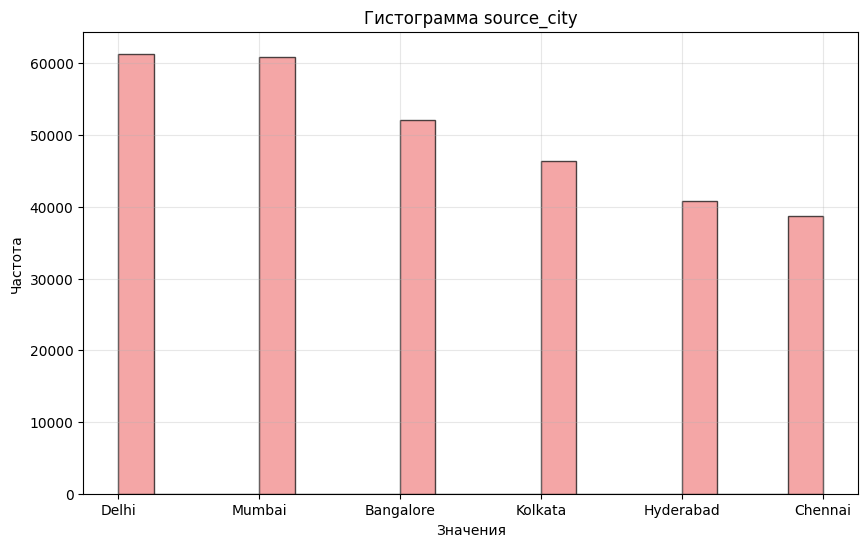

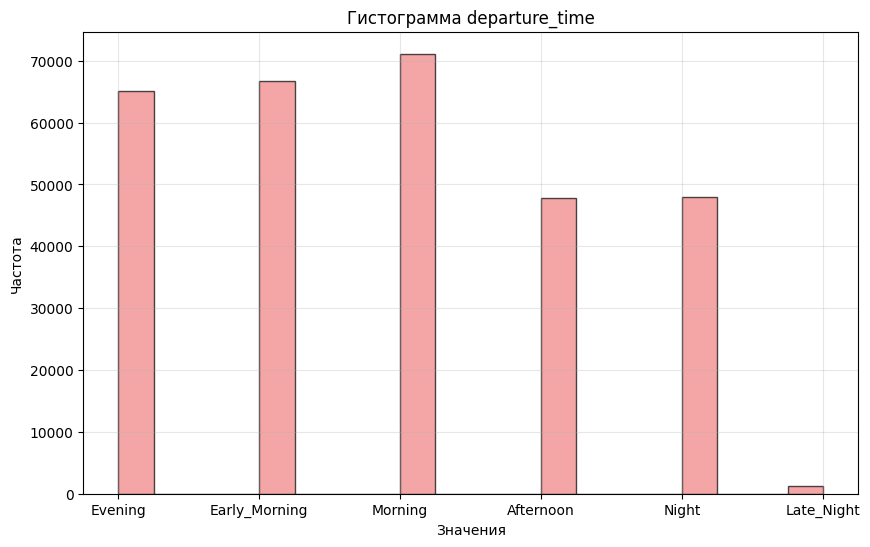

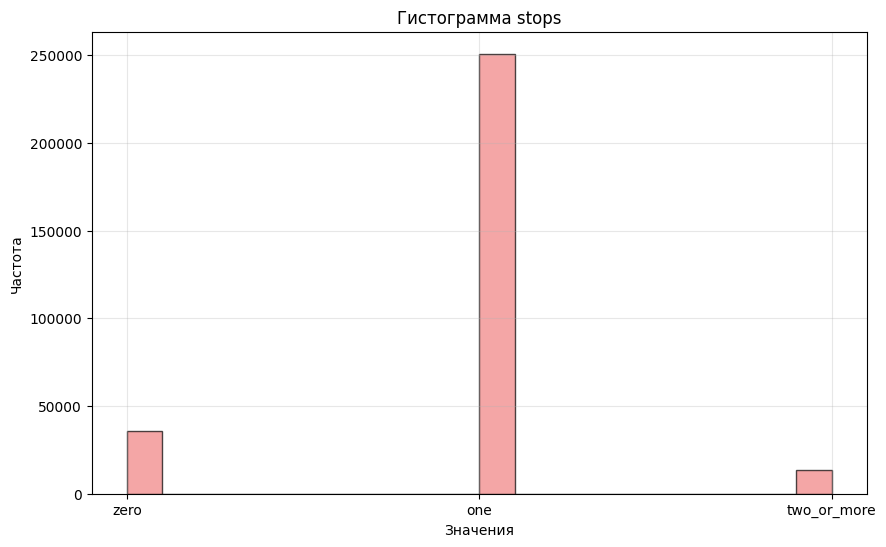

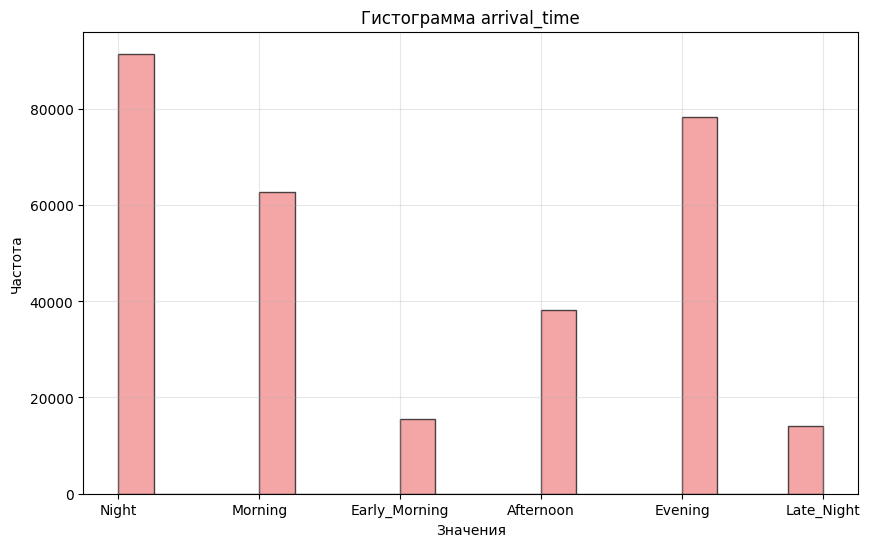

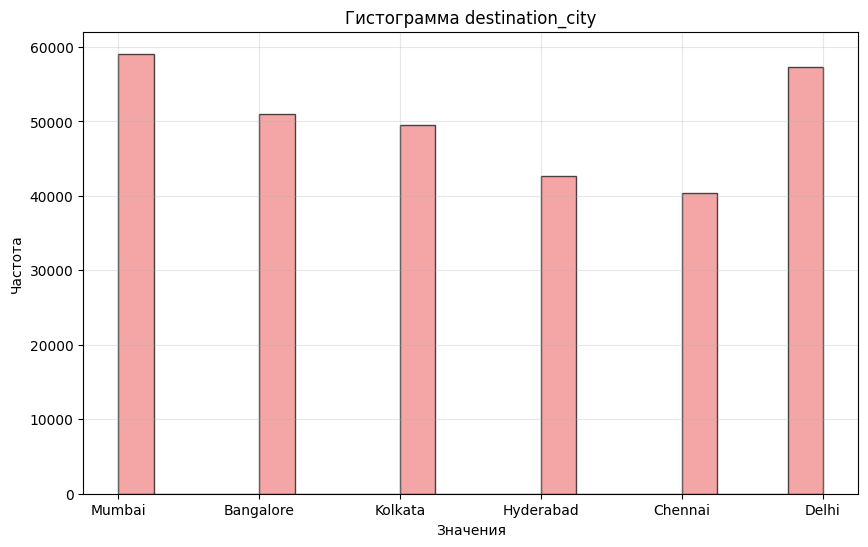

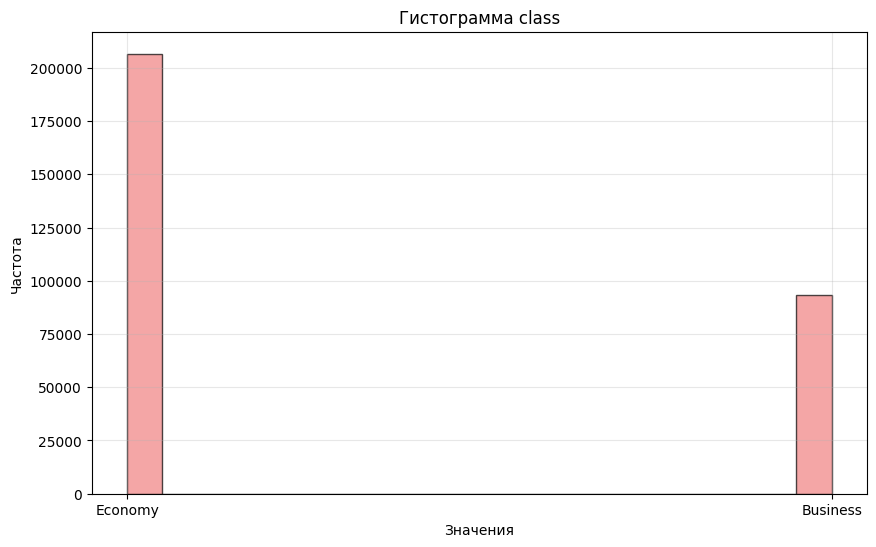

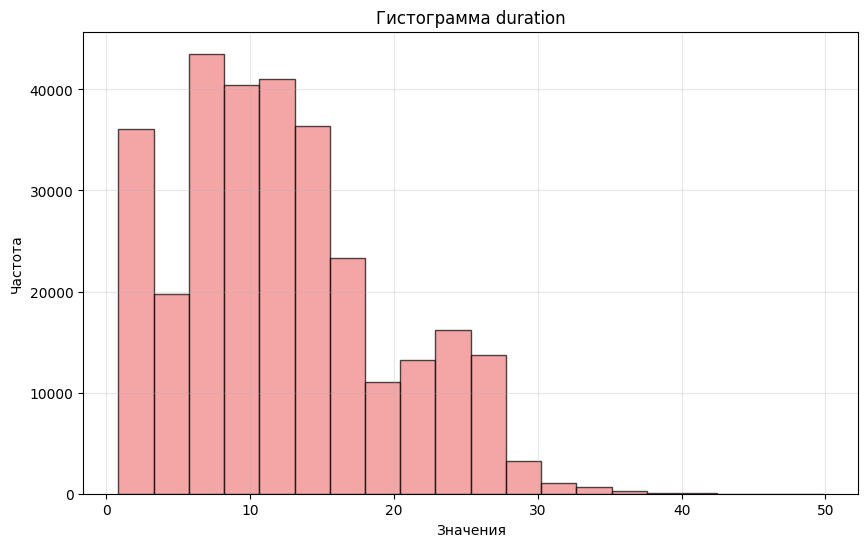

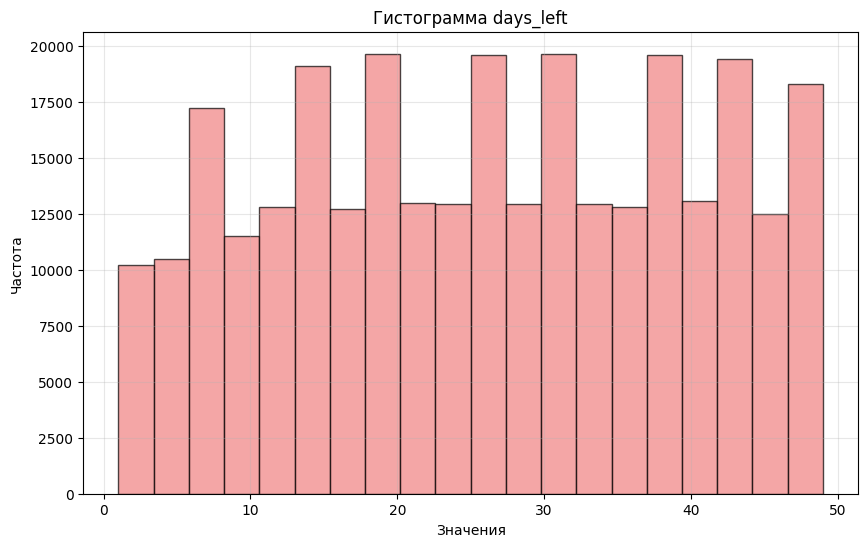

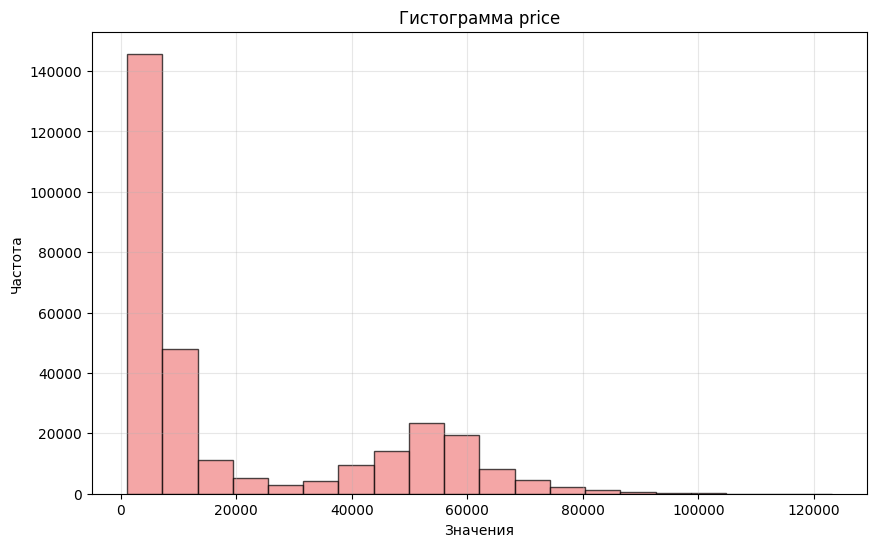

In [37]:
columns = data.columns

for col in columns:
    plt.figure(figsize=(10, 6))
    plt.hist(data[col], bins='sturges', alpha=0.7, color='lightcoral', edgecolor='black')
    plt.title(f'Гистограмма {col}')
    plt.xlabel('Значения')
    plt.ylabel('Частота')
    plt.grid(alpha=0.3)
    plt.show()


## Кодирование категориальных признаков

In [38]:
for col in cat_cols:
    data[col] = pd.factorize(data[col])[0]

data.describe()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
count,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000,300153.000000
mean,3.059356,2.201487,1.835910,0.924312,1.969939,2.420719,0.311464,12.221021,26.004751,20889.660523
std,1.459060,1.684757,1.378931,0.398106,1.737428,1.783519,0.463093,7.191997,13.561004,22697.767366
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.830000,1.000000,1105.000000
25%,2.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,6.830000,15.000000,4783.000000
50%,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,0.000000,11.250000,26.000000,7425.000000
75%,5.000000,4.000000,3.000000,1.000000,4.000000,4.000000,1.000000,16.170000,38.000000,42521.000000
max,5.000000,5.000000,5.000000,2.000000,5.000000,5.000000,1.000000,49.830000,49.000000,123071.000000


## Нормализуем признаки

In [39]:
scaler = StandardScaler()
data[[*cat_cols, *num_cols]] = scaler.fit_transform(data[[*cat_cols, *num_cols]])
data.describe()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
count,3.001530e+05,3.001530e+05,3.001530e+05,3.001530e+05,3.001530e+05,3.001530e+05,300153.000000,3.001530e+05,3.001530e+05,300153.000000
mean,-1.302945e-16,-4.848166e-17,3.636124e-17,8.332785e-17,4.848166e-17,-1.515052e-17,0.000000,7.272249e-17,1.219617e-16,20889.660523
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002,1.000002e+00,1.000002e+00,22697.767366
min,-2.096803e+00,-1.306711e+00,-1.331403e+00,-2.321779e+00,-1.133826e+00,-1.357273e+00,-0.672576,-1.583849e+00,-1.843875e+00,1105.000000
25%,-7.260552e-01,-7.131527e-01,-6.062027e-01,1.901209e-01,-1.133826e+00,-7.965831e-01,-0.672576,-7.495873e-01,-8.115011e-01,4783.000000
50%,-7.260552e-01,-1.195944e-01,1.189979e-01,1.901209e-01,-5.582621e-01,-2.358929e-01,-0.672576,-1.350143e-01,-3.503368e-04,7425.000000
75%,1.330066e+00,1.067522e+00,8.441986e-01,1.901209e-01,1.168431e+00,8.854875e-01,1.486822,5.490805e-01,8.845414e-01,42521.000000
max,1.330066e+00,1.661080e+00,2.294600e+00,2.702021e+00,1.743995e+00,1.446178e+00,1.486822,5.229290e+00,1.695692e+00,123071.000000


In [40]:
for col in columns:
    _, p_value = stats.normaltest(data[col])
    print(f"{col} распределена{' НЕ' if p_value <= 0.05 else ''} нормально")


airline распределена НЕ нормально
source_city распределена НЕ нормально
departure_time распределена НЕ нормально
stops распределена НЕ нормально
arrival_time распределена НЕ нормально
destination_city распределена НЕ нормально
class распределена НЕ нормально
duration распределена НЕ нормально
days_left распределена НЕ нормально
price распределена НЕ нормально


## Матрица корреляций
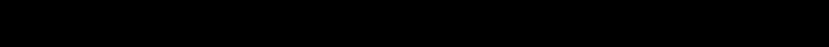

In [41]:
corr_matrix = data.corr(method='spearman')
corr_matrix

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
airline,1.000000,-0.006766,-0.020165,-0.023133,-0.020168,-0.020973,-0.008020,0.051463,-0.011020,-0.026077
source_city,-0.006766,1.000000,0.100101,0.061638,0.012140,0.021113,0.006165,0.068926,0.008020,0.035055
departure_time,-0.020165,0.100101,1.000000,0.004502,-0.005091,0.003822,0.005209,-0.030394,0.009720,0.000318
stops,-0.023133,0.061638,0.004502,1.000000,0.019047,-0.019744,0.005528,0.512912,-0.007995,0.223185
arrival_time,-0.020168,0.012140,-0.005091,0.019047,1.000000,0.052925,-0.028579,-0.038506,0.005814,-0.030330
destination_city,-0.020973,0.021113,0.003822,-0.019744,0.052925,1.000000,-0.014011,-0.015892,0.005862,-0.043451
class,-0.008020,0.006165,0.005209,0.005528,-0.028579,-0.014011,1.000000,0.163679,-0.013120,0.801583
duration,0.051463,0.068926,-0.030394,0.512912,-0.038506,-0.015892,0.163679,1.000000,-0.033094,0.318841
days_left,-0.011020,0.008020,0.009720,-0.007995,0.005814,0.005862,-0.013120,-0.033094,1.000000,-0.267019
price,-0.026077,0.035055,0.000318,0.223185,-0.030330,-0.043451,0.801583,0.318841,-0.267019,1.000000


Т.к. данные не распределены нормально, используем метод Спирмена.

По таблице можно сделать вывод, что основное влияние оказывают stops, class, duration и days_left.

- **Stops** - слабая положительная корреляция: чем больше остановок, тем дороже билет
- **Class** - сильная положительная корреляция: бизнесс-класс оказывает значительное влияние на цену
- **Duration** - относительно слабая положительная корреляция: чем дольше полет, тем выше цена
- **Days left** - слабая отрицательная корреляция: чем меньше дней до полета в момент покупки билета, тем выше цена.

## Расчет коэффициента VIF

In [42]:
X = data.drop(columns=[dep_var])  # price должен быть только в y
y = data[dep_var]

X_const = add_constant(X)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i+1) for i in range(len(X.columns))]

print(vif_data)


            Feature       VIF
0           airline  1.008685
1       source_city  1.016301
2    departure_time  1.011461
3             stops  1.295390
4      arrival_time  1.005826
5  destination_city  1.003810
6             class  1.026314
7          duration  1.328953
8         days_left  1.001990


VIF близок к 1, поэтому можно сделать вывод, что мультиколлинеарность слабая или отсутствует

## Построение регрессионных моделей (линейной и гребневой).

In [43]:
def get_stats(X, is_log = False, log_coefs = False):
    X_train, X_test, y_train, y_test = train_test_split(X, np.log1p(y) if is_log else y, test_size=0.2, random_state=42)

    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)

    y_pred_lin = lin_reg.predict(X_test)

    if log_coefs:
        print('Коэффициенты линейной модели')
        for feat, coef in zip([*cat_cols, *num_cols], lin_reg.coef_):
            print(f'\t{feat}: {coef:.3f}')

    rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
    r2_lin = r2_score(y_test, y_pred_lin)
    mape_lin = mean_absolute_percentage_error(y_test, y_pred_lin)

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores_lin = cross_val_score(lin_reg, X, y, cv=cv, scoring='r2')

    ridge = Ridge(alpha=1.0)
    ridge.fit(X_train, y_train)

    y_pred_ridge = ridge.predict(X_test)

    rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
    r2_ridge = r2_score(y_test, y_pred_ridge)
    mape_ridge = mean_absolute_percentage_error(y_test, y_pred_ridge)

    cv_scores_ridge = cross_val_score(ridge, X, y, cv=cv, scoring='r2')

    res = pd.DataFrame({
        'Метрика': ['RMSE', 'R²', 'MAPE (%)', 'Средний R^2'],
        'Линейная регрессия': [rmse_lin, r2_lin, mape_lin * 100, f"{cv_scores_lin.mean():.4f}"],
        'Гребневая регрессия': [rmse_ridge, r2_ridge, mape_ridge * 100, f"{cv_scores_ridge.mean():.4f}"],
    })

    print(res)

get_stats(X)

       Метрика Линейная регрессия Гребневая регрессия
0         RMSE        7053.156755         7053.156567
1           R²           0.903494            0.903494
2     MAPE (%)          43.877948           43.877955
3  Средний R^2             0.9036              0.9036


## Анализ результатов

- Обе модели объясняют 90% дисперсии в данных - это очень хороший результат. Средняя ошибка прогноза - окола 7 тысяч, что допустимо для ценообразования.
- Кросс-валидация подтверждает, что модель стабильна — нет переобучения, метрика совпадает с тестом.
- Резальтаты в двух моделях идентичны до 4 знака, что объясняется отсутствием мультиколлинеарности.

Самое большое влияние имеет коэффициент class, что соответствует таблице корреляции.

In [44]:
get_stats(X, True, False)

       Метрика Линейная регрессия Гребневая регрессия
0         RMSE           0.366064            0.366064
1           R²           0.891806            0.891806
2     MAPE (%)           3.160253            3.160254
3  Средний R^2             0.9036              0.9036


Также можно применить логарфирование целевой переменной для уменьшения % ошибки.

Исходное число признаков: 9
После PCA осталось компонент: 8
Кумулятивная сумма: [0.16771282 0.2912578  0.40957735 0.52090735 0.63198716 0.74113628
 0.84569402 0.94418415]


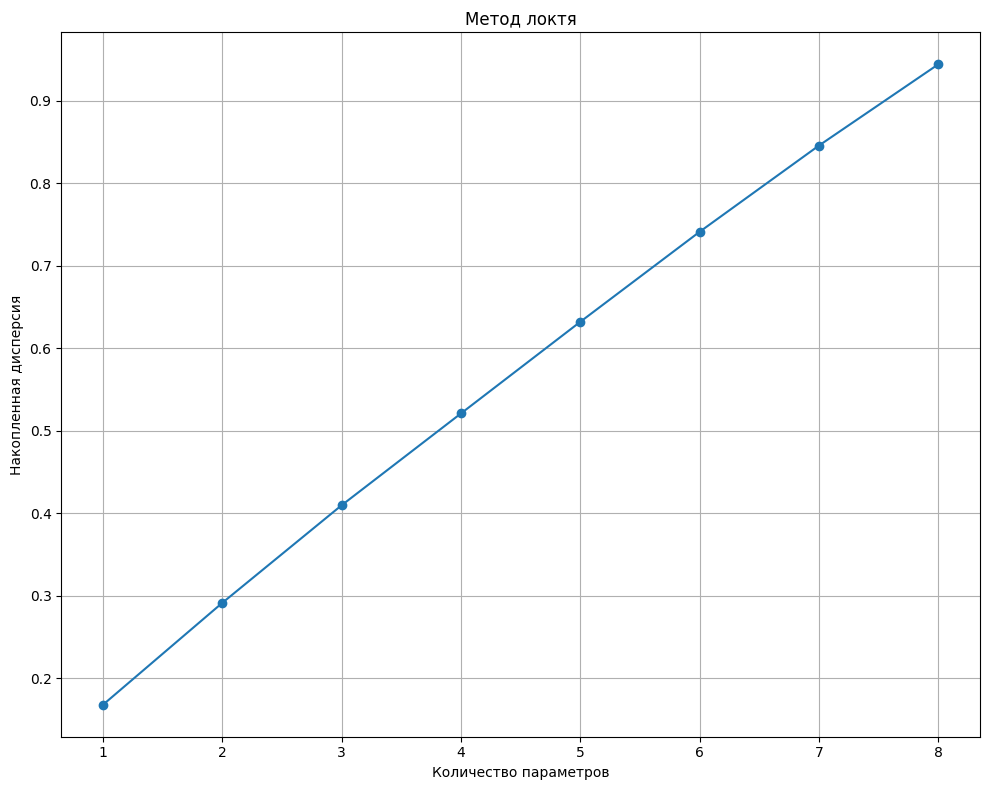

In [45]:
pca = PCA(n_components=0.85)
X_reduced = pca.fit_transform(X)

print(f"Исходное число признаков: {X.shape[1]}")
print(f"После PCA осталось компонент: {X_reduced.shape[1]}")

explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

print(f"Кумулятивная сумма: {explained_variance_ratio}")

plt.figure(figsize=(10, 8))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.title('Метод локтя')
plt.xlabel('Количество параметров')
plt.ylabel('Накопленная дисперсия')
plt.grid(True)
plt.tight_layout()
plt.show()


Мультиколлинеарность отсутствует (VIF близко к 1), поэтому PCA применятся в данном случае для снижения размерности. Таким образом, на 8 из 9 параметров накопленная дисперсия превышает 85% и становится около 94%.

In [46]:
get_stats(X_reduced)

       Метрика Линейная регрессия Гребневая регрессия
0         RMSE        7934.383897         7934.383628
1           R²           0.877873            0.877873
2     MAPE (%)          50.564514           50.564473
3  Средний R^2             0.8776              0.8776


## Анализ регрессионных моделей построенных по PCA

Показатели модели незначительно ухудшились (R² с 0.89 до 0.87), что связано с изначальным отсутствием мультиколлинеарности и снижением количества параметров.

| Метод	| Данные | RMSE	              | R²           | MAPE (%) |
| --- | --- |--------------------|--------------|----------|
| Линейная регрессия | Исходные | 	7934 | 	0.877| 	51%     |
| Линейная регрессия | PCA | 	7053              | 0.903        | 44%      |
| Гребневая регрессия | Исходные | 	7934 | 	0.877| 	51%     |
| Гребневая регрессия | PCA | 	7053              | 0.903        | 44%      |

## Заключение

В ходе лабораторной работы изучены основы линейной регрессии и факторного анализа на датасете о ценах на авиабилеты.

Наибольшее влияние оказывают класс полета, количество пересадок, длительность и заблаговременность покупки.

И линейная, и гребневая модели показали отличное качество (R^2 - 90%), различий между ними не было из-за отсутствия мультиколлинеарности.

Применение PCA хоть и позволило уменьшить количество независимых переменных, но качественно ухудшило модель (R^2 - 87%), т.к. усложнило интерпретацию коэффициентов в виду отсутствия мультиколлинеарности изначально.

Полученные результаты подтверждают эффективность линейных методов для оценки влияния факторов на целевую переменную и построения предсказательных моделей.